Initialize the environment

In [13]:
from TamGen_Demo import TamGenDemo, prepare_pdb_data
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

download_worker = TamGenDemo(
    data="./TamGen_Demo_Data",
    ckpt="checkpoints/crossdock_pdb_A10/checkpoint_best.pt",
    use_conditional=True
)

pdb_id = "1F0N"
prepare_pdb_data(pdb_id,)
download_worker.reload_data(subset="gen_" + pdb_id.lower())

Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation_coord', num_workers=1, skip_invalid_size_inputs_valid_test=False, max_tokens=1024, max_sentences=None, required_batch_size_multiple=8, dataset_impl=None, gen_subset='gen_8fln', num_shards=1, shard_id=0, path='checkpoints/crossdock_pdb_A10/checkpoint_best.pt', remove_bpe=None, quiet=False, model_overrides='{}', results_path=None, beam=20, nbest=20, max_len_a=0, max_len_b=200, min_len=1, match_source_len=False, no_early_stop=False, unnormalized=False, no_beamable_mm=False, lenpen=1, unkpen=0, replace_unk=None, sacrebleu=False, score_reference=False, prefix_size=0, prefix_string

/root/miniconda3/envs/TamGen/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]INFO:structure_file.py:Downloading 1f0n.cif from https://files.rcsb.org/view/1f0n.cif to database/PDBlib/1f0n.cif


Processing 1F0N


100%|██████████| 1/1 [00:05<00:00,  5.01s/it]


Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation', source_lang='tg', target_lang='m1', trainpref=None, validpref=None, testpref='TamGen_Demo_Data/src/gen_1f0n', destdir='TamGen_Demo_Data/tmp', thresholdtgt=0, thresholdsrc=0, tgtdict='/workspace/workspace/TamGen/dict/dict.m1.txt', srcdict='/workspace/workspace/TamGen/dict/dict.tg.txt', nwordstgt=-1, nwordssrc=-1, alignfile=None, dataset_impl='mmap', joined_dictionary=False, only_source=False, padding_factor=8, workers=4)
| [tg] Dictionary: 24 types
| [tg] TamGen_Demo_Data/src/gen_1f0n.tg: 2 sents, 83 tokens, 0.0% replaced by <unk>
| [m1] Dictionary: 961 types
| [m1] TamGen_D

In [14]:
from TamGen_RL import TamGenRL
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

worker = TamGenRL(
    data="./TamGen_Demo_Data",
    ckpt="checkpoints/crossdocked_model/checkpoint_best.pt",
    use_conditional=True
)

Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation_coord', num_workers=1, skip_invalid_size_inputs_valid_test=False, max_tokens=1024, max_sentences=None, required_batch_size_multiple=8, dataset_impl=None, gen_subset='gen_8fln', num_shards=1, shard_id=0, path='checkpoints/crossdocked_model/checkpoint_best.pt', remove_bpe=None, quiet=False, model_overrides='{}', results_path=None, beam=20, nbest=20, max_len_a=0, max_len_b=200, min_len=1, match_source_len=False, no_early_stop=False, unnormalized=False, no_beamable_mm=False, lenpen=1, unkpen=0, replace_unk=None, sacrebleu=False, score_reference=False, prefix_size=0, prefix_string

gpt_model/checkpoint_best.pt


2025-06-01 10:29:50,498 [INFO] TamGenRL initialized on device: cuda:0
2025-06-01 10:29:50,501 [INFO] Detected latent dimension: 256


Set the PDB you want to generate cmpds

In [15]:
worker.reload_data(subset="gen_" + pdb_id.lower())

final_smiles = worker.sample(
    m_sample=1000,      # Tiny
    num_iter=10,      # Just 2 iterations  
    latent_dim=256,
    alpha=0.4,
    top_k=10,
    lambda_sas=0.3,
    lambda_logp=0.1,
    lambda_mw=0.1,
    maxseed=20,       # Just 2 seeds
    use_cuda=torch.cuda.is_available()
)

2025-06-01 10:29:52,730 [INFO] 🚀 Starting TamGenRL feedback loop optimization
2025-06-01 10:29:52,731 [INFO]    Target: 1000 molecules × 10 iterations
2025-06-01 10:29:52,732 [INFO]    Device: cuda:0, Batch size: 4
2025-06-01 10:29:52,733 [INFO] 
🔄 Iteration 1/10 (α=0.400)
2025-06-01 10:29:52,734 [INFO] 🌱 Generating initial molecules with TamGen...


| loaded 2 examples from: ./TamGen_Demo_Data/gen_1f0n.tg-m1.tg
| loaded 2 examples from: ./TamGen_Demo_Data/gen_1f0n.tg-m1.m1
| ./TamGen_Demo_Data gen_1f0n tg-m1 2 examples
| loaded 2 examples from: ./TamGen_Demo_Data/gen_1f0n.tg-m1.tg.coord


Initial generation:   4%|▍         | 40/1000 [00:19<07:52,  2.03it/s]
2025-06-01 10:30:12,412 [INFO]    ✓ Generated 40 initial molecules
2025-06-01 10:30:12,413 [INFO]    ✓ Diversity: 12/40 (30.00%)
2025-06-01 10:30:12,414 [WARNING] Low diversity detected (30.00% < 70.00%)
2025-06-01 10:30:12,415 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 40 samples
   Using top-10 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 40/40 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.4454
   ✓ Training complete: 50 epochs, final loss: 0.4454
🧭 Computing optimal shift direction...


2025-06-01 10:30:13,638 [INFO]    ✓ Saved results for iteration 1
2025-06-01 10:30:13,639 [INFO]    ✓ Generated 40 molecules
2025-06-01 10:30:13,640 [INFO]    ✓ Diversity: 12/40 (30.00%)
2025-06-01 10:30:13,641 [INFO]    ✓ Reward: μ=2.478, σ=0.217, max=2.990
2025-06-01 10:30:13,642 [INFO]    ✓ Time: 20.9s
2025-06-01 10:30:13,645 [INFO] 
🔄 Iteration 2/10 (α=0.369)
2025-06-01 10:30:13,646 [INFO] 🔄 Generating from 40 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 7.1210
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.478, σ=0.217
   • Valid molecules: 40/40
   • Shift magnitude: 7.1210
   • Applied noise: σ=0.0500
   ✓ Good diversity: 12/40 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 40 shifted vectors


2025-06-01 10:30:22,547 [INFO]    ✓ Generated 40/40 valid SMILES
2025-06-01 10:30:22,548 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 40 samples
   Using top-10 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 40/40 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0190
   ✓ Training complete: 60 epochs, final loss: 0.0190
🧭 Computing optimal shift direction...


2025-06-01 10:30:23,807 [INFO]    ✓ Saved results for iteration 2
2025-06-01 10:30:23,808 [INFO]    ✓ Generated 40 molecules
2025-06-01 10:30:23,809 [INFO]    ✓ Diversity: 8/40 (20.00%)
2025-06-01 10:30:23,811 [INFO]    ✓ Reward: μ=2.576, σ=0.107, max=2.990
2025-06-01 10:30:23,812 [INFO]    ✓ Time: 10.2s
2025-06-01 10:30:23,813 [INFO] 
🔄 Iteration 3/10 (α=0.338)
2025-06-01 10:30:23,815 [INFO] 🔄 Generating from 40 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 7.0113
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.576, σ=0.107
   • Valid molecules: 40/40
   • Shift magnitude: 7.0113
   • Applied noise: σ=0.0700
   ⚠️  Low diversity detected: 8/40 unique SMILES
      Consider increasing noise_sigma or reducing shift_alpha
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 40 shifted vectors


2025-06-01 10:30:31,838 [INFO]    ✓ Generated 40/40 valid SMILES
2025-06-01 10:30:31,839 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 40 samples
   Using top-10 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 40/40 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0220
   ✓ Training complete: 70 epochs, final loss: 0.0220
🧭 Computing optimal shift direction...


2025-06-01 10:30:32,938 [INFO]    ✓ Saved results for iteration 3
2025-06-01 10:30:32,939 [INFO]    ✓ Generated 40 molecules
2025-06-01 10:30:32,940 [INFO]    ✓ Diversity: 7/40 (17.50%)
2025-06-01 10:30:32,942 [INFO]    ✓ Reward: μ=2.571, σ=0.139, max=2.831
2025-06-01 10:30:32,943 [INFO]    ✓ Time: 9.1s
2025-06-01 10:30:32,944 [INFO] 
🔄 Iteration 4/10 (α=0.307)
2025-06-01 10:30:32,945 [INFO] 🔄 Generating from 40 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 6.6764
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.571, σ=0.139
   • Valid molecules: 40/40
   • Shift magnitude: 6.6764
   • Applied noise: σ=0.0900
   ⚠️  Low diversity detected: 7/40 unique SMILES
      Consider increasing noise_sigma or reducing shift_alpha
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 40 shifted vectors


2025-06-01 10:30:40,059 [INFO]    ✓ Generated 40/40 valid SMILES
2025-06-01 10:30:40,060 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 40 samples
   Using top-10 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 40/40 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0074
   ✓ Training complete: 80 epochs, final loss: 0.0074
🧭 Computing optimal shift direction...


2025-06-01 10:30:41,260 [INFO]    ✓ Saved results for iteration 4
2025-06-01 10:30:41,261 [INFO]    ✓ Generated 40 molecules
2025-06-01 10:30:41,262 [INFO]    ✓ Diversity: 11/40 (27.50%)
2025-06-01 10:30:41,263 [INFO]    ✓ Reward: μ=2.593, σ=0.180, max=3.075
2025-06-01 10:30:41,265 [INFO]    ✓ Time: 8.3s
2025-06-01 10:30:41,267 [INFO] 
🔄 Iteration 5/10 (α=0.276)
2025-06-01 10:30:41,268 [INFO] 🔄 Generating from 40 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 6.3219
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.593, σ=0.180
   • Valid molecules: 40/40
   • Shift magnitude: 6.3219
   • Applied noise: σ=0.1100
   ⚠️  Low diversity detected: 11/40 unique SMILES
      Consider increasing noise_sigma or reducing shift_alpha
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 40 shifted vectors


2025-06-01 10:30:47,813 [INFO]    ✓ Generated 40/40 valid SMILES
2025-06-01 10:30:47,815 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 40 samples
   Using top-10 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 40/40 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0336
   ✓ Training complete: 90 epochs, final loss: 0.0336
🧭 Computing optimal shift direction...


2025-06-01 10:30:49,123 [INFO]    ✓ Saved results for iteration 5
2025-06-01 10:30:49,124 [INFO]    ✓ Generated 40 molecules
2025-06-01 10:30:49,125 [INFO]    ✓ Diversity: 15/40 (37.50%)
2025-06-01 10:30:49,126 [INFO]    ✓ Reward: μ=2.681, σ=0.204, max=3.152
2025-06-01 10:30:49,128 [INFO]    ✓ Time: 7.9s
2025-06-01 10:30:49,130 [INFO] 
🔄 Iteration 6/10 (α=0.244)
2025-06-01 10:30:49,131 [INFO] 🔄 Generating from 40 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 6.7852
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.681, σ=0.204
   • Valid molecules: 40/40
   • Shift magnitude: 6.7852
   • Applied noise: σ=0.1300
   ✓ Good diversity: 15/40 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 40 shifted vectors


2025-06-01 10:30:54,751 [INFO]    ✓ Generated 40/40 valid SMILES
2025-06-01 10:30:54,752 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 40 samples
   Using top-10 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 40/40 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0168
   ✓ Training complete: 100 epochs, final loss: 0.0168
🧭 Computing optimal shift direction...


2025-06-01 10:30:55,947 [INFO]    ✓ Saved results for iteration 6
2025-06-01 10:30:55,948 [INFO]    ✓ Generated 40 molecules
2025-06-01 10:30:55,949 [INFO]    ✓ Diversity: 14/40 (35.00%)
2025-06-01 10:30:55,951 [INFO]    ✓ Reward: μ=2.771, σ=0.165, max=3.075
2025-06-01 10:30:55,952 [INFO]    ✓ Time: 6.8s
2025-06-01 10:30:55,954 [INFO] 
🔄 Iteration 7/10 (α=0.213)
2025-06-01 10:30:55,955 [INFO] 🔄 Generating from 40 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 6.0747
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.771, σ=0.165
   • Valid molecules: 40/40
   • Shift magnitude: 6.0747
   • Applied noise: σ=0.1500
   ✓ Good diversity: 14/40 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 40 shifted vectors


2025-06-01 10:31:01,669 [INFO]    ✓ Generated 40/40 valid SMILES
2025-06-01 10:31:01,670 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 40 samples
   Using top-10 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 40/40 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0245
   ✓ Training complete: 100 epochs, final loss: 0.0245
🧭 Computing optimal shift direction...


2025-06-01 10:31:02,869 [INFO]    ✓ Saved results for iteration 7
2025-06-01 10:31:02,870 [INFO]    ✓ Generated 40 molecules
2025-06-01 10:31:02,871 [INFO]    ✓ Diversity: 20/40 (50.00%)
2025-06-01 10:31:02,872 [INFO]    ✓ Reward: μ=2.809, σ=0.220, max=3.084
2025-06-01 10:31:02,874 [INFO]    ✓ Time: 6.9s
2025-06-01 10:31:02,875 [INFO] 
🔄 Iteration 8/10 (α=0.182)
2025-06-01 10:31:02,877 [INFO] 🔄 Generating from 40 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.5290
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.809, σ=0.220
   • Valid molecules: 40/40
   • Shift magnitude: 5.5290
   • Applied noise: σ=0.1700
   ✓ Good diversity: 20/40 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 40 shifted vectors


2025-06-01 10:31:08,851 [INFO]    ✓ Generated 40/40 valid SMILES
2025-06-01 10:31:08,853 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 40 samples
   Using top-10 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 40/40 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0229
   ✓ Training complete: 100 epochs, final loss: 0.0229
🧭 Computing optimal shift direction...


2025-06-01 10:31:10,025 [INFO]    ✓ Saved results for iteration 8
2025-06-01 10:31:10,026 [INFO]    ✓ Generated 40 molecules
2025-06-01 10:31:10,027 [INFO]    ✓ Diversity: 21/40 (52.50%)
2025-06-01 10:31:10,029 [INFO]    ✓ Reward: μ=2.815, σ=0.229, max=3.138
2025-06-01 10:31:10,030 [INFO]    ✓ Time: 7.2s
2025-06-01 10:31:10,032 [INFO] 
🔄 Iteration 9/10 (α=0.151)
2025-06-01 10:31:10,033 [INFO] 🔄 Generating from 40 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.8319
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.815, σ=0.229
   • Valid molecules: 40/40
   • Shift magnitude: 5.8319
   • Applied noise: σ=0.1900
   ✓ Good diversity: 21/40 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 40 shifted vectors


2025-06-01 10:31:15,815 [INFO]    ✓ Generated 40/40 valid SMILES
2025-06-01 10:31:15,816 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 40 samples
   Using top-10 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 40/40 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0215
   ✓ Training complete: 100 epochs, final loss: 0.0215
🧭 Computing optimal shift direction...


2025-06-01 10:31:17,004 [INFO]    ✓ Saved results for iteration 9
2025-06-01 10:31:17,006 [INFO]    ✓ Generated 40 molecules
2025-06-01 10:31:17,007 [INFO]    ✓ Diversity: 29/40 (72.50%)
2025-06-01 10:31:17,009 [INFO]    ✓ Reward: μ=2.763, σ=0.252, max=3.084
2025-06-01 10:31:17,010 [INFO]    ✓ Time: 7.0s
2025-06-01 10:31:17,012 [INFO] 
🔄 Iteration 10/10 (α=0.120)
2025-06-01 10:31:17,013 [INFO] 🔄 Generating from 40 latent vectors...


   ✓ gradient-based optimization complete, direction norm: 5.1486
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.763, σ=0.252
   • Valid molecules: 40/40
   • Shift magnitude: 5.1486
   • Applied noise: σ=0.2100
   ✓ Good diversity: 29/40 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 40 shifted vectors


2025-06-01 10:31:22,415 [INFO]    ✓ Generated 40/40 valid SMILES
2025-06-01 10:31:22,416 [INFO] 📊 Optimizing latent space...


🧠 Starting centroid shift optimization for 40 samples
   Using top-10 samples for optimization
[INFO] LatentRewardModel initialized on device: cuda
📊 Computing molecular rewards...
   ✓ Computed rewards for 40/40 valid molecules
🎯 Training reward model...
[INFO] Training complete. Final train loss: 0.0138
   ✓ Training complete: 100 epochs, final loss: 0.0138
🧭 Computing optimal shift direction...


2025-06-01 10:31:23,588 [INFO]    ✓ Saved results for iteration 10
2025-06-01 10:31:23,589 [INFO]    ✓ Generated 40 molecules
2025-06-01 10:31:23,590 [INFO]    ✓ Diversity: 31/40 (77.50%)
2025-06-01 10:31:23,592 [INFO]    ✓ Reward: μ=2.827, σ=0.249, max=3.084
2025-06-01 10:31:23,593 [INFO]    ✓ Time: 6.6s
2025-06-01 10:31:23,595 [INFO] 
📈 Final Optimization Summary:
2025-06-01 10:31:23,596 [INFO]    Iteration | Molecules | Unique | Mean Reward | Max Reward | Time
2025-06-01 10:31:23,597 [INFO]    ---------|-----------|--------|-------------|------------|-----
2025-06-01 10:31:23,599 [INFO]           1 |        40 |     12 |       2.478 |      2.990 | 20.9s
2025-06-01 10:31:23,600 [INFO]           2 |        40 |      8 |       2.576 |      2.990 | 10.2s
2025-06-01 10:31:23,601 [INFO]           3 |        40 |      7 |       2.571 |      2.831 |  9.1s
2025-06-01 10:31:23,602 [INFO]           4 |        40 |     11 |       2.593 |      3.075 |  8.3s
2025-06-01 10:31:23,604 [INFO]        

   ✓ gradient-based optimization complete, direction norm: 5.0837
🔄 Applying latent space shifts...
📈 Optimization summary:
   • Reward distribution: μ=2.827, σ=0.249
   • Valid molecules: 40/40
   • Shift magnitude: 5.0837
   • Applied noise: σ=0.2300
   ✓ Good diversity: 31/40 unique SMILES
[INFO] Cleared stored latent vectors and rewards.
✅ Centroid shift optimization complete: 40 shifted vectors


Visualize

In [16]:
for i in final_smiles:
    print(i)

CCCCC(C)(C)C(=O)O
CC(C)CCC(=O)O
CC(C)(CC(=O)O)CC(=O)O
CC(C)=CCOP(=O)(O)O
CC(C)(C)C(=O)O
CCCCCCCCC(=O)C(=O)O
CC(C)CCCC(C)C
CCCCCCCCCCC(=O)O
C=C(OP(=O)(O)O)C(=O)O
CC(C)CCCC(C)CC(=O)O
CC(C)=CCC/C(C)=C/C(=O)O
CC(C)CCCC(C)CCC(=O)O
CCCCCCCCCCCCC(=O)O
CC(C)CCC(=O)O
CCCCCCCCCCCCCC(=O)O
CC(C)=CC(=O)O
CC(C)CCC(=O)O
CC(C)CCCC(C)CC(=O)O
CCCCCCCCC(=O)O
CCCCCCCCCCCCCCCC(=O)O
CC(C)CCC(C)CC(=O)O
CCCCCCCCCCCCCCCCC(=O)O
CCCCCCCCCC(=O)O
CCCCCCCCC(=O)O
CC(C)(C)C(=O)O
CCCCCCCCCCCC(=O)O
CC(C)CCC(=O)O
CC(O)=N[C@@H](CCC(=O)O)C(=O)O
CC(C)CCC[C@@H](C)CCC[C@@H](C)CCCC(=O)O
CC(C)CCCC(C)CCC(=O)O
CC(C)(O)C(=O)O
CC(C)(C)/C=C/C(=O)O
CCCCCCCCCC(=O)O
CC(C)(C)CCC(=O)O
CC(C)CC(=O)O
CC(C)CCCC(C)CC(=O)O
CC(C)(CC(=O)O)C(=O)O
CC(=O)CC(=O)O
CCCCCCCC(=O)O
CC(=O)C(=O)O


In [17]:
from rdkit import Chem

valid_smiles = []
invalid_smiles = []

for smi in final_smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        valid_smiles.append(smi)
    else:
        invalid_smiles.append(smi)

print(f"✅ Valid: {len(valid_smiles)}")
print(f"❌ Invalid: {len(invalid_smiles)}")

✅ Valid: 40
❌ Invalid: 0


🔬 REWARD CONVERGENCE ANALYSIS
📊 Found 10 iteration files
   ⚠️ Warning: Invalid reward value at line 1 in latent_logs/results_iter_1.tsv
   Iter 1: 40 molecules, 12 unique, reward range [1.911, 2.990]
   ⚠️ Warning: Invalid reward value at line 1 in latent_logs/results_iter_10.tsv
   Iter 2: 40 molecules, 31 unique, reward range [2.023, 3.084]
   ⚠️ Warning: Invalid reward value at line 1 in latent_logs/results_iter_2.tsv
   Iter 3: 40 molecules, 14 unique, reward range [1.863, 2.881]
   ⚠️ Warning: Invalid reward value at line 1 in latent_logs/results_iter_3.tsv
   Iter 4: 40 molecules, 9 unique, reward range [2.311, 3.082]
   ⚠️ Warning: Invalid reward value at line 1 in latent_logs/results_iter_4.tsv
   Iter 5: 40 molecules, 11 unique, reward range [2.311, 2.883]
   ⚠️ Warning: Invalid reward value at line 1 in latent_logs/results_iter_5.tsv
   Iter 6: 40 molecules, 18 unique, reward range [2.279, 3.205]
   ⚠️ Warning: Invalid reward value at line 1 in latent_logs/results_iter_6.tsv

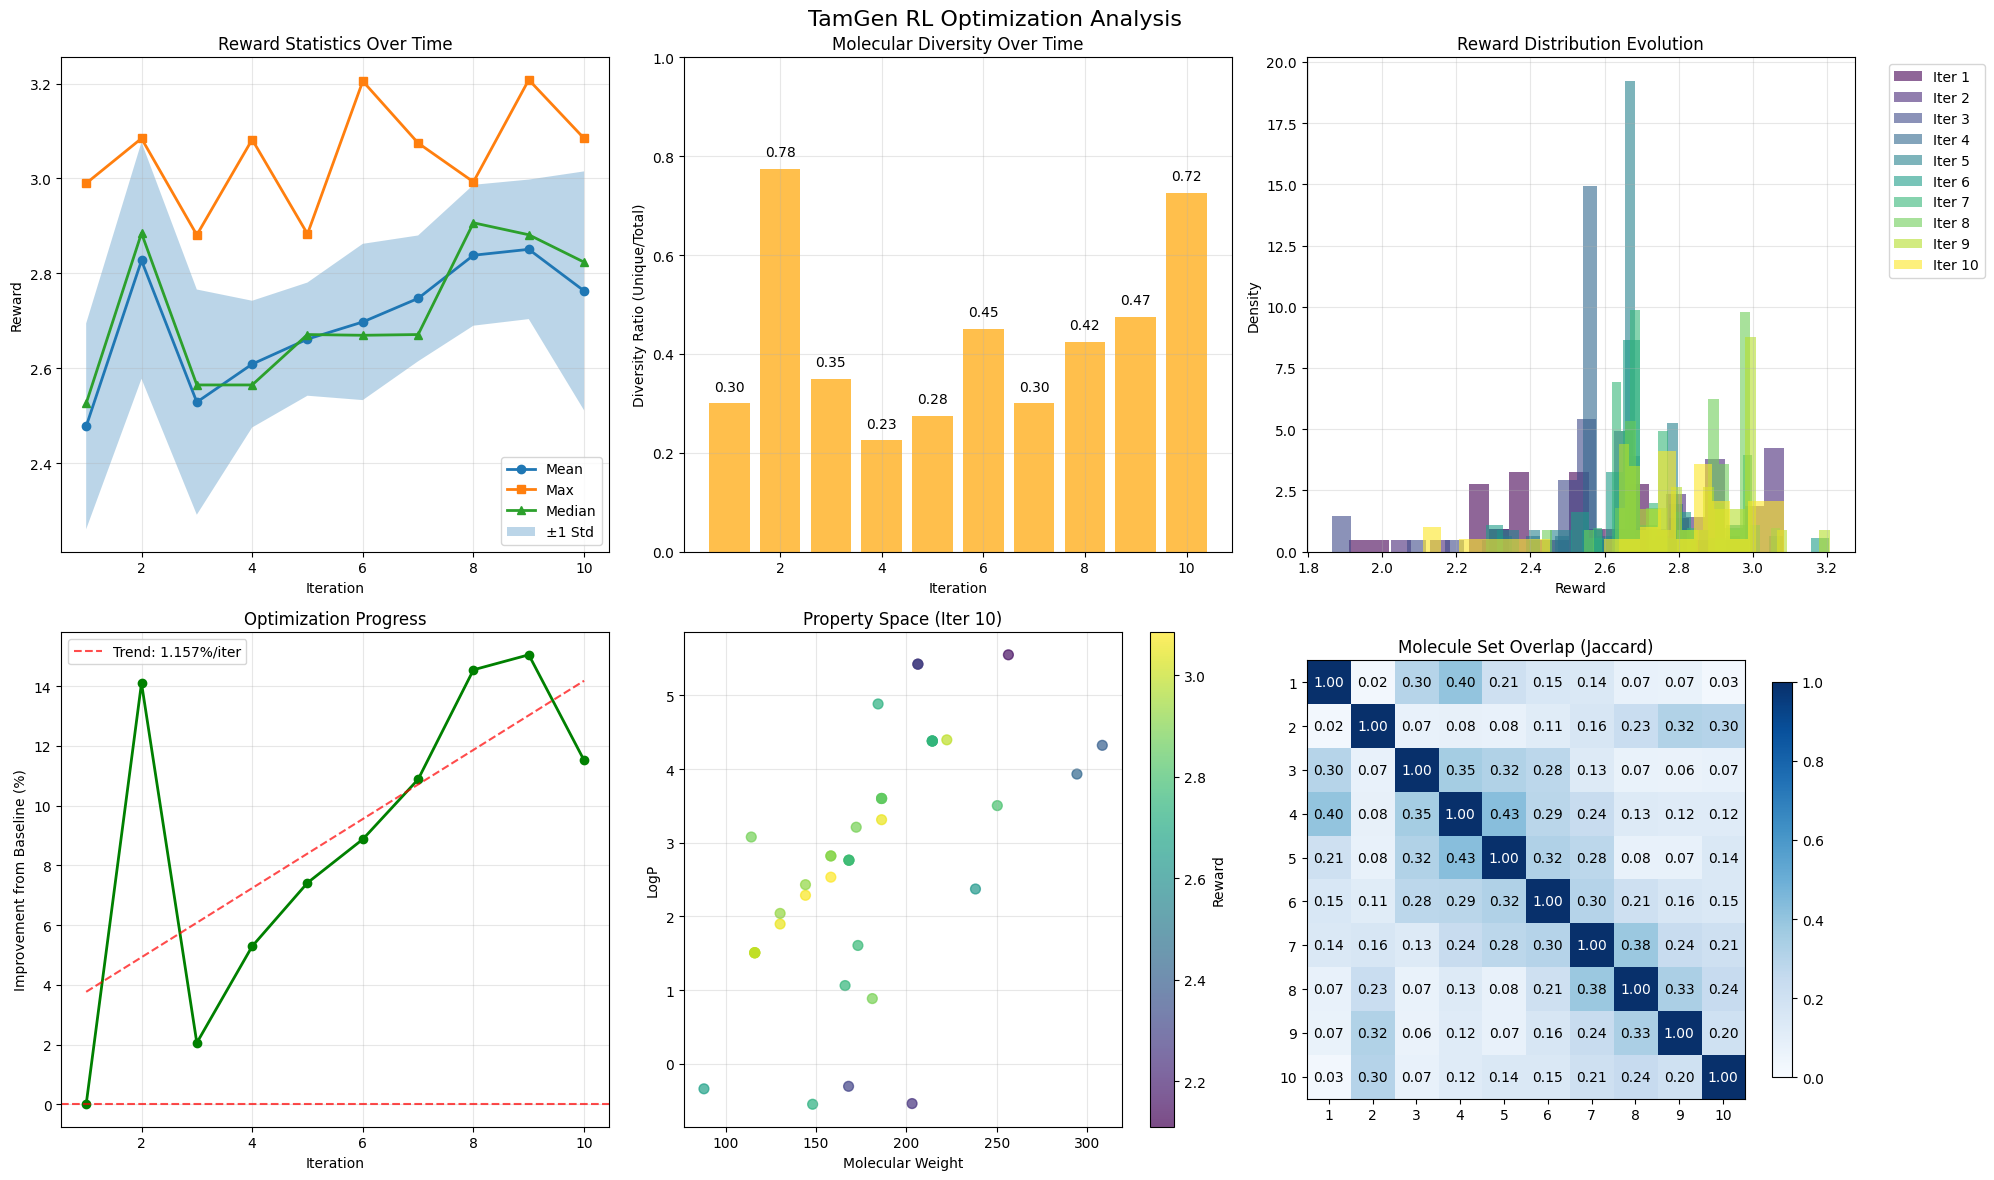


📈 DETAILED ANALYSIS
📈 TRENDING: Mean rewards still changing (std = 0.057)
📊 OVERALL IMPROVEMENT: +11.5% from baseline
🏆 BEST MOLECULE: Cc1ccc(CCC[C@H](CC(=O)O)C(=O)O)cc1
   Reward: 3.208 (Iteration 9)
✅ DIVERSITY IMPROVING: 0.015/iteration

💡 RECOMMENDATIONS
📉 OPTIMIZATION ISSUES: Performance declining

🔍 LONG RUN INSIGHTS:
   - Total iterations analyzed: 10
   - Total unique molecules discovered: 80
   - Improvement over last 10 iterations: +11.5%
   - Total molecules evaluated: 400

📋 SUMMARY STATISTICS
   Best reward found: 3.208
   Final mean reward: 2.763
   Current diversity: 72.5%
   Iterations completed: 10
✅ Analysis completed successfully!


In [18]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def analyze_reward_convergence():
    """
    Comprehensive analysis of reward function convergence and molecular properties
    """
    
    print("🔬 REWARD CONVERGENCE ANALYSIS")
    print("=" * 60)
    
    # Load reward files
    reward_files = sorted(glob.glob('latent_logs/results_iter_*.tsv'))
    if not reward_files:
        print("❌ No reward files found in latent_logs/")
        return
    
    print(f"📊 Found {len(reward_files)} iteration files")
    
    # Parse data with robust error handling
    iteration_data = {}
    all_molecules = set()
    
    for i, f in enumerate(reward_files):
        rewards = []
        molecules = []
        try:
            with open(f, 'r', encoding='utf-8') as fin:
                for line_num, line in enumerate(fin):
                    line = line.strip()
                    if not line:  # Skip empty lines
                        continue
                    parts = line.split('\t')
                    if len(parts) >= 2:
                        mol_smiles = parts[0].strip()
                        try:
                            reward = float(parts[1])
                            # Basic sanity check on reward values
                            if not np.isnan(reward) and not np.isinf(reward):
                                rewards.append(reward)
                                molecules.append(mol_smiles)
                                all_molecules.add(mol_smiles)
                        except (ValueError, TypeError):
                            print(f"   ⚠️ Warning: Invalid reward value at line {line_num+1} in {f}")
                            continue
        except Exception as e:
            print(f"   ❌ Error reading {f}: {e}")
            continue
        
        if rewards:  # Only add if we have valid data
            iteration_data[i+1] = {
                'rewards': np.array(rewards),
                'molecules': molecules,
                'mean': np.mean(rewards),
                'max': np.max(rewards),
                'median': np.median(rewards),
                'std': np.std(rewards),
                'unique_count': len(set(molecules))
            }
            
            print(f"   Iter {i+1}: {len(rewards)} molecules, {len(set(molecules))} unique, "
                  f"reward range [{np.min(rewards):.3f}, {np.max(rewards):.3f}]")
        else:
            print(f"   ❌ No valid data in {f}")
    
    if not iteration_data:
        print("❌ No valid iteration data found!")
        return None
    
    # Create comprehensive plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('TamGen RL Optimization Analysis', fontsize=16)
    
    iterations = sorted(list(iteration_data.keys()))
    n_iterations = len(iterations)
    
    # 1. Reward Statistics Over Time
    ax1 = axes[0, 0]
    means = [iteration_data[i]['mean'] for i in iterations]
    maxs = [iteration_data[i]['max'] for i in iterations]
    medians = [iteration_data[i]['median'] for i in iterations]
    stds = [iteration_data[i]['std'] for i in iterations]
    
    ax1.plot(iterations, means, 'o-', label='Mean', linewidth=2)
    ax1.plot(iterations, maxs, 's-', label='Max', linewidth=2)
    ax1.plot(iterations, medians, '^-', label='Median', linewidth=2)
    ax1.fill_between(iterations, 
                     [m - s for m, s in zip(means, stds)],
                     [m + s for m, s in zip(means, stds)],
                     alpha=0.3, label='±1 Std')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Reward')
    ax1.set_title('Reward Statistics Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Diversity Analysis
    ax2 = axes[0, 1]
    total_counts = [len(iteration_data[i]['molecules']) for i in iterations]
    unique_counts = [iteration_data[i]['unique_count'] for i in iterations]
    diversity_ratios = [u/t for u, t in zip(unique_counts, total_counts)]
    
    ax2.bar(iterations, diversity_ratios, alpha=0.7, color='orange')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Diversity Ratio (Unique/Total)')
    ax2.set_title('Molecular Diversity Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # Add text annotations
    for i, ratio in zip(iterations, diversity_ratios):
        ax2.text(i, ratio + 0.02, f'{ratio:.2f}', ha='center', va='bottom')
    
    # 3. Reward Distribution Evolution (sample for high iteration counts)
    ax3 = axes[0, 2]
    # For many iterations, only show a subset to avoid cluttered plot
    if n_iterations > 10:
        step = max(1, n_iterations // 8)  # Show max 8 distributions
        sample_iterations = iterations[::step]
        colors = plt.cm.viridis(np.linspace(0, 1, len(sample_iterations)))
        for iter_idx, color in zip(sample_iterations, colors):
            rewards = iteration_data[iter_idx]['rewards']
            ax3.hist(rewards, bins=min(20, len(rewards)//2), alpha=0.6, 
                    label=f'Iter {iter_idx}', color=color, density=True)
        ax3.set_title(f'Reward Distribution Evolution (sampled)')
    else:
        colors = plt.cm.viridis(np.linspace(0, 1, len(iterations)))
        for i, color in zip(iterations, colors):
            rewards = iteration_data[i]['rewards']
            ax3.hist(rewards, bins=min(20, len(rewards)//2), alpha=0.6, 
                    label=f'Iter {i}', color=color, density=True)
        ax3.set_title('Reward Distribution Evolution')
    
    ax3.set_xlabel('Reward')
    ax3.set_ylabel('Density')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # 4. Convergence Analysis
    ax4 = axes[1, 0]
    # Calculate running improvement
    improvements = []
    base_mean = means[0]
    for mean in means:
        improvements.append((mean - base_mean) / abs(base_mean) * 100)
    
    ax4.plot(iterations, improvements, 'o-', linewidth=2, color='green')
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Improvement from Baseline (%)')
    ax4.set_title('Optimization Progress')
    ax4.grid(True, alpha=0.3)
    
    # Add trend line
    if len(iterations) > 2:
        try:
            z = np.polyfit(iterations, improvements, 1)
            p = np.poly1d(z)
            ax4.plot(iterations, p(iterations), '--', alpha=0.7, color='red',
                    label=f'Trend: {z[0]:.3f}%/iter')
            ax4.legend()
        except np.RankWarning:
            pass  # Skip trend line if fitting fails
    
    # 5. Molecular Property Analysis (if we can parse SMILES)
    ax5 = axes[1, 1]
    try:
        # Analyze molecular properties for last iteration
        last_iter = max(iterations)
        last_molecules = iteration_data[last_iter]['molecules']
        last_rewards = iteration_data[last_iter]['rewards']
        
        # Calculate molecular properties
        mw_values = []
        logp_values = []
        valid_rewards = []
        
        for mol_smiles, reward in zip(last_molecules, last_rewards):
            mol = Chem.MolFromSmiles(mol_smiles)
            if mol is not None:
                mw = Descriptors.MolWt(mol)
                logp = Descriptors.MolLogP(mol)
                mw_values.append(mw)
                logp_values.append(logp)
                valid_rewards.append(reward)
        
        if mw_values:
            scatter = ax5.scatter(mw_values, logp_values, c=valid_rewards, 
                                cmap='viridis', alpha=0.7, s=50)
            ax5.set_xlabel('Molecular Weight')
            ax5.set_ylabel('LogP')
            ax5.set_title(f'Property Space (Iter {last_iter})')
            plt.colorbar(scatter, ax=ax5, label='Reward')
            ax5.grid(True, alpha=0.3)
        else:
            ax5.text(0.5, 0.5, 'No valid molecules\nfor property analysis', 
                    ha='center', va='center', transform=ax5.transAxes)
            ax5.set_title('Property Analysis Failed')
    
    except Exception as e:
        ax5.text(0.5, 0.5, f'Property analysis failed:\n{str(e)}', 
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Property Analysis Error')
    
    # 6. Molecule Overlap Analysis (optimize for many iterations)
    ax6 = axes[1, 2]
    if len(iterations) > 1:
        # For many iterations, sample to keep matrix readable
        if n_iterations > 15:
            step = max(1, n_iterations // 10)  # Show max 10x10 matrix
            sample_iters = iterations[::step]
            overlap_matrix = np.zeros((len(sample_iters), len(sample_iters)))
            for i, iter1 in enumerate(sample_iters):
                for j, iter2 in enumerate(sample_iters):
                    set1 = set(iteration_data[iter1]['molecules'])
                    set2 = set(iteration_data[iter2]['molecules'])
                    if len(set1.union(set2)) > 0:
                        overlap = len(set1.intersection(set2)) / len(set1.union(set2))
                    else:
                        overlap = 0
                    overlap_matrix[i, j] = overlap
            
            im = ax6.imshow(overlap_matrix, cmap='Blues', vmin=0, vmax=1)
            ax6.set_xticks(range(len(sample_iters)))
            ax6.set_yticks(range(len(sample_iters)))
            ax6.set_xticklabels([f'{i}' for i in sample_iters], rotation=45)
            ax6.set_yticklabels([f'{i}' for i in sample_iters])
            ax6.set_title(f'Molecule Overlap (sampled)')
        else:
            overlap_matrix = np.zeros((len(iterations), len(iterations)))
            for i, iter1 in enumerate(iterations):
                for j, iter2 in enumerate(iterations):
                    set1 = set(iteration_data[iter1]['molecules'])
                    set2 = set(iteration_data[iter2]['molecules'])
                    if len(set1.union(set2)) > 0:
                        overlap = len(set1.intersection(set2)) / len(set1.union(set2))
                    else:
                        overlap = 0
                    overlap_matrix[i, j] = overlap
            
            im = ax6.imshow(overlap_matrix, cmap='Blues', vmin=0, vmax=1)
            ax6.set_xticks(range(len(iterations)))
            ax6.set_yticks(range(len(iterations)))
            ax6.set_xticklabels([f'{i}' for i in iterations])
            ax6.set_yticklabels([f'{i}' for i in iterations])
            ax6.set_title('Molecule Set Overlap (Jaccard)')
            
            # Add text annotations only for smaller matrices
            if len(iterations) <= 10:
                for i in range(len(iterations)):
                    for j in range(len(iterations)):
                        ax6.text(j, i, f'{overlap_matrix[i, j]:.2f}',
                                ha='center', va='center', 
                                color='white' if overlap_matrix[i, j] > 0.5 else 'black')
        
        plt.colorbar(im, ax=ax6, shrink=0.8)
    else:
        ax6.text(0.5, 0.5, 'Need multiple iterations\nfor overlap analysis', 
                ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Molecule Overlap Analysis')
    
    plt.tight_layout()
    
    # Save plot with error handling
    try:
        plt.savefig('latent_logs/reward_analysis.png', dpi=300, bbox_inches='tight')
        print("📊 Analysis plot saved to 'latent_logs/reward_analysis.png'")
    except Exception as e:
        print(f"⚠️ Could not save plot: {e}")
    
    plt.show()
    
    # Print detailed analysis
    print("\n📈 DETAILED ANALYSIS")
    print("=" * 60)
    
    # Convergence assessment with robust statistics
    if len(iterations) >= 3:
        recent_window = min(5, len(iterations))  # Use last 5 iterations or all if fewer
        recent_means = means[-recent_window:]
        mean_change = np.std(recent_means)
        if mean_change < 0.01:
            print("🔄 CONVERGENCE: Mean rewards have stabilized (std < 0.01)")
        else:
            print(f"📈 TRENDING: Mean rewards still changing (std = {mean_change:.3f})")
        
        # Check for improvement
        total_improvement = (means[-1] - means[0]) / abs(means[0]) * 100
        print(f"📊 OVERALL IMPROVEMENT: {total_improvement:+.1f}% from baseline")
        
        # Best molecules
        try:
            best_iter = max(iterations, key=lambda x: iteration_data[x]['max'])
            best_reward = iteration_data[best_iter]['max']
            best_idx = np.argmax(iteration_data[best_iter]['rewards'])
            best_molecule = iteration_data[best_iter]['molecules'][best_idx]
            
            print(f"🏆 BEST MOLECULE: {best_molecule}")
            print(f"   Reward: {best_reward:.3f} (Iteration {best_iter})")
        except Exception as e:
            print(f"⚠️ Could not identify best molecule: {e}")
        
        # Diversity trend
        try:
            diversity_trend = np.polyfit(iterations, diversity_ratios, 1)[0]
            if diversity_trend < -0.01:
                print(f"⚠️ DIVERSITY DECLINING: {diversity_trend:.3f}/iteration")
            elif diversity_trend > 0.01:
                print(f"✅ DIVERSITY IMPROVING: {diversity_trend:.3f}/iteration")
            else:
                print(f"➡️ DIVERSITY STABLE: {diversity_trend:.3f}/iteration")
        except Exception:
            print("⚠️ Could not calculate diversity trend")
    
    # Recommendations with robust checks
    print("\n💡 RECOMMENDATIONS")
    print("=" * 30)
    
    latest_diversity = diversity_ratios[-1] if diversity_ratios else 0
    if latest_diversity < 0.1:
        print("🔧 INCREASE EXPLORATION: Very low diversity detected")
        print("   - Increase noise_sigma (try 0.1-0.2)")
        print("   - Reduce shift_alpha (try 0.2-0.3)")
        print("   - Add diversity penalty to reward function")
    
    if len(iterations) >= 3:
        try:
            recent_improvement = (means[-1] - means[-3]) / abs(means[-3]) * 100
            if abs(recent_improvement) < 1:
                print("🔄 CONSIDER STOPPING: Minimal recent improvement")
                print("   - Try different hyperparameters")
                print("   - Or accept current results")
            elif recent_improvement > 0:
                print("✅ CONTINUE OPTIMIZATION: Still improving")
            else:
                print("📉 OPTIMIZATION ISSUES: Performance declining")
        except Exception:
            print("⚠️ Could not assess recent improvement")
    
    # Additional insights for long runs
    if len(iterations) >= 10:
        print(f"\n🔍 LONG RUN INSIGHTS:")
        print(f"   - Total iterations analyzed: {len(iterations)}")
        print(f"   - Total unique molecules discovered: {len(all_molecules)}")
        
        # Check for plateaus
        if len(means) >= 10:
            last_10_improvement = (means[-1] - means[-10]) / abs(means[-10]) * 100
            print(f"   - Improvement over last 10 iterations: {last_10_improvement:+.1f}%")
            
        # Memory usage estimate
        total_molecules = sum(len(iteration_data[i]['molecules']) for i in iterations)
        print(f"   - Total molecules evaluated: {total_molecules}")
    
    print(f"\n📋 SUMMARY STATISTICS")
    print(f"   Best reward found: {max(maxs):.3f}")
    print(f"   Final mean reward: {means[-1]:.3f}")
    print(f"   Current diversity: {latest_diversity:.1%}")
    print(f"   Iterations completed: {len(iterations)}")
    
    return iteration_data

if __name__ == "__main__":
    result = analyze_reward_convergence()
    if result is not None:
        print("✅ Analysis completed successfully!")
    else:
        print("❌ Analysis failed - check your data files!")

🔬 ENHANCED MOLECULAR OPTIMIZATION ANALYSIS
📊 Found 10 iteration files
   Iter 1: 40 molecules, 12 unique, reward range [1.911, 2.990]
   Iter 2: 40 molecules, 25 unique, reward range [2.023, 3.087]
   Iter 3: 40 molecules, 14 unique, reward range [1.863, 2.881]
   Iter 4: 40 molecules, 9 unique, reward range [2.311, 3.082]
   Iter 5: 40 molecules, 11 unique, reward range [2.311, 2.883]
   Iter 6: 40 molecules, 18 unique, reward range [2.279, 3.205]
   Iter 7: 40 molecules, 12 unique, reward range [2.568, 3.075]
   Iter 8: 40 molecules, 17 unique, reward range [2.431, 2.993]
   Iter 9: 40 molecules, 19 unique, reward range [2.638, 3.208]
   Iter 10: 40 molecules, 27 unique, reward range [2.023, 3.084]


📊 Enhanced analysis plot saved to 'latent_logs/enhanced_reward_analysis.png'


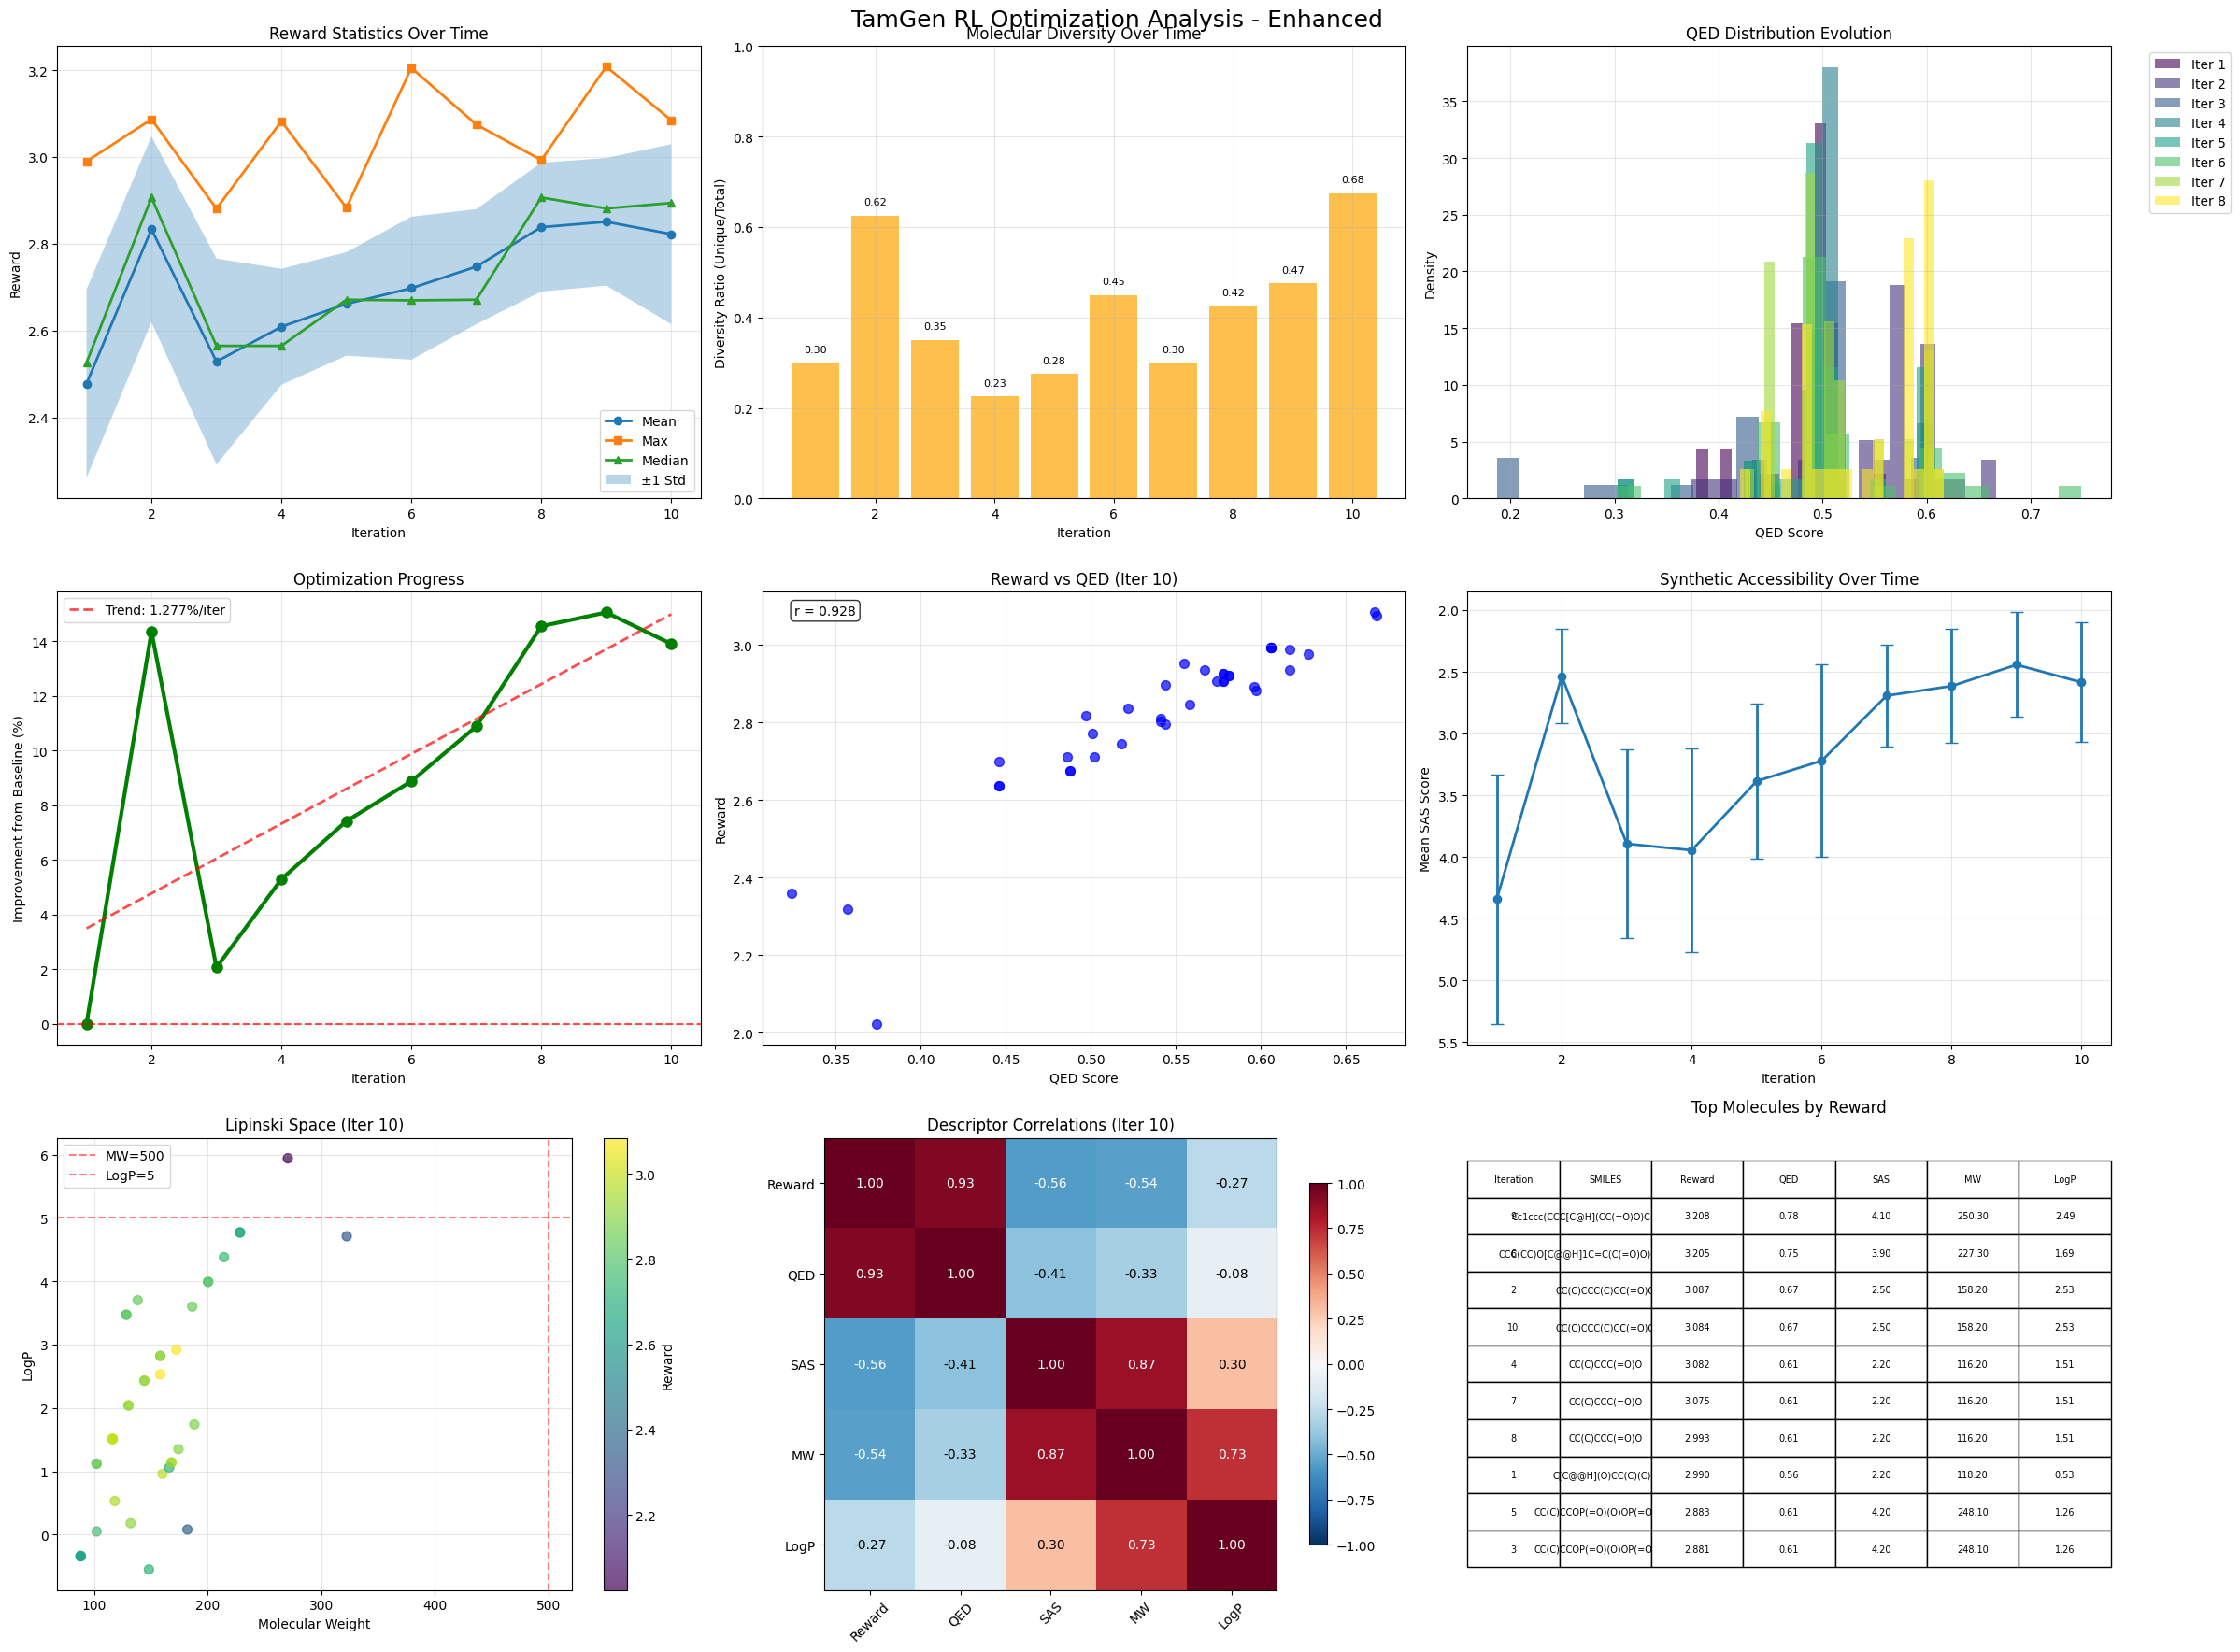


📈 ENHANCED DETAILED ANALYSIS
📈 TRENDING: Mean rewards still changing (std = 0.059)
📊 OVERALL IMPROVEMENT: +13.9% from baseline
🏆 BEST MOLECULE: Cc1ccc(CCC[C@H](CC(=O)O)C(=O)O)cc1
   Reward: 3.208 (Iteration 9)
   Descriptors: QED: 0.779 | SAS: 4.100 | MW: 250.300 | LogP: 2.490

🧬 DESCRIPTOR TRENDS
QED: ↗️ +0.0055/iteration
SAS: ↘️ -0.1621/iteration
MW: ↘️ -8.0487/iteration
LogP: ↗️ +0.1574/iteration

💡 ENHANCED RECOMMENDATIONS

📋 ENHANCED SUMMARY
   Best reward found: 3.208
   Final mean reward: 2.822
   Current diversity: 67.5%
   Total unique molecules: 72
   Iterations completed: 10
✅ Enhanced analysis completed successfully!


In [19]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def analyze_reward_convergence():
    """
    Comprehensive analysis of reward function convergence and molecular properties
    Enhanced for TSV files with molecular descriptors (SMILES, Reward, QED, SAS, MW, LogP)
    """
    
    print("🔬 ENHANCED MOLECULAR OPTIMIZATION ANALYSIS")
    print("=" * 70)
    
    # Load reward files
    reward_files = sorted(glob.glob('latent_logs/results_iter_*.tsv'))
    if not reward_files:
        print("❌ No reward files found in latent_logs/")
        return
    
    print(f"📊 Found {len(reward_files)} iteration files")
    
    # Parse data with robust error handling and enhanced descriptors
    iteration_data = {}
    all_molecules = set()
    
    for i, f in enumerate(reward_files):
        try:
            # Try to read as TSV with pandas first
            df = pd.read_csv(f, sep='\t', encoding='utf-8')
            
            # Handle different possible column names
            smiles_col = None
            reward_col = None
            
            for col in df.columns:
                col_lower = col.lower().strip()
                if col_lower in ['smiles', 'smile']:
                    smiles_col = col
                elif col_lower in ['reward', 'score']:
                    reward_col = col
            
            if smiles_col is None or reward_col is None:
                print(f"   ⚠️ Warning: Could not find SMILES/Reward columns in {f}")
                continue
                
            # Clean and validate data
            df = df.dropna(subset=[smiles_col, reward_col])
            df = df[df[smiles_col].str.strip() != '']
            
            # Convert reward to numeric
            df[reward_col] = pd.to_numeric(df[reward_col], errors='coerce')
            df = df.dropna(subset=[reward_col])
            
            # Filter out invalid reward values
            df = df[np.isfinite(df[reward_col])]
            
            if len(df) == 0:
                print(f"   ❌ No valid data in {f}")
                continue
            
            # Extract data
            molecules = df[smiles_col].tolist()
            rewards = df[reward_col].values
            
            # Extract additional descriptors if available
            descriptors = {}
            for desc_col in ['QED', 'SAS', 'MW', 'LogP']:
                if desc_col in df.columns:
                    desc_values = pd.to_numeric(df[desc_col], errors='coerce')
                    descriptors[desc_col] = desc_values.values
            
            # Store iteration data
            iteration_data[i+1] = {
                'rewards': rewards,
                'molecules': molecules,
                'descriptors': descriptors,
                'mean': np.mean(rewards),
                'max': np.max(rewards),
                'median': np.median(rewards),
                'std': np.std(rewards),
                'unique_count': len(set(molecules)),
                'dataframe': df  # Store for easy access
            }
            
            all_molecules.update(molecules)
            
            print(f"   Iter {i+1}: {len(rewards)} molecules, {len(set(molecules))} unique, "
                  f"reward range [{np.min(rewards):.3f}, {np.max(rewards):.3f}]")
            
        except Exception as e:
            print(f"   ❌ Error reading {f}: {e}")
            continue
    
    if not iteration_data:
        print("❌ No valid iteration data found!")
        return None
    
    # Create comprehensive plots
    fig, axes = plt.subplots(3, 3, figsize=(24, 18))
    fig.suptitle('TamGen RL Optimization Analysis - Enhanced', fontsize=18)
    
    iterations = sorted(list(iteration_data.keys()))
    n_iterations = len(iterations)
    
    # 1. Reward Statistics Over Time
    ax1 = axes[0, 0]
    means = [iteration_data[i]['mean'] for i in iterations]
    maxs = [iteration_data[i]['max'] for i in iterations]
    medians = [iteration_data[i]['median'] for i in iterations]
    stds = [iteration_data[i]['std'] for i in iterations]
    
    ax1.plot(iterations, means, 'o-', label='Mean', linewidth=2, markersize=6)
    ax1.plot(iterations, maxs, 's-', label='Max', linewidth=2, markersize=6)
    ax1.plot(iterations, medians, '^-', label='Median', linewidth=2, markersize=6)
    ax1.fill_between(iterations, 
                     [m - s for m, s in zip(means, stds)],
                     [m + s for m, s in zip(means, stds)],
                     alpha=0.3, label='±1 Std')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Reward')
    ax1.set_title('Reward Statistics Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Diversity Analysis
    ax2 = axes[0, 1]
    total_counts = [len(iteration_data[i]['molecules']) for i in iterations]
    unique_counts = [iteration_data[i]['unique_count'] for i in iterations]
    diversity_ratios = [u/t for u, t in zip(unique_counts, total_counts)]
    
    bars = ax2.bar(iterations, diversity_ratios, alpha=0.7, color='orange')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Diversity Ratio (Unique/Total)')
    ax2.set_title('Molecular Diversity Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # Add text annotations
    for i, ratio in zip(iterations, diversity_ratios):
        ax2.text(i, ratio + 0.02, f'{ratio:.2f}', ha='center', va='bottom', fontsize=8)
    
    # 3. QED Distribution Over Time (if available)
    ax3 = axes[0, 2]
    if any('QED' in iteration_data[i]['descriptors'] for i in iterations):
        colors = plt.cm.viridis(np.linspace(0, 1, min(8, len(iterations))))
        step = max(1, len(iterations) // 8)
        sample_iterations = iterations[::step]
        
        for iter_idx, color in zip(sample_iterations, colors):
            if 'QED' in iteration_data[iter_idx]['descriptors']:
                qed_values = iteration_data[iter_idx]['descriptors']['QED']
                qed_values = qed_values[~np.isnan(qed_values)]
                if len(qed_values) > 0:
                    ax3.hist(qed_values, bins=20, alpha=0.6, label=f'Iter {iter_idx}', 
                            color=color, density=True)
        
        ax3.set_xlabel('QED Score')
        ax3.set_ylabel('Density')
        ax3.set_title('QED Distribution Evolution')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'QED data not available', ha='center', va='center', 
                transform=ax3.transAxes, fontsize=12)
        ax3.set_title('QED Distribution Evolution')
    
    # 4. Convergence Analysis
    ax4 = axes[1, 0]
    improvements = []
    base_mean = means[0]
    for mean in means:
        improvements.append((mean - base_mean) / abs(base_mean) * 100)
    
    ax4.plot(iterations, improvements, 'o-', linewidth=3, color='green', markersize=8)
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Improvement from Baseline (%)')
    ax4.set_title('Optimization Progress')
    ax4.grid(True, alpha=0.3)
    
    # Add trend line
    if len(iterations) > 2:
        try:
            z = np.polyfit(iterations, improvements, 1)
            p = np.poly1d(z)
            ax4.plot(iterations, p(iterations), '--', alpha=0.7, color='red',
                    linewidth=2, label=f'Trend: {z[0]:.3f}%/iter')
            ax4.legend()
        except np.RankWarning:
            pass
    
    # 5. Reward vs QED Correlation (if available)
    ax5 = axes[1, 1]
    if any('QED' in iteration_data[i]['descriptors'] for i in iterations):
        last_iter = max(iterations)
        if 'QED' in iteration_data[last_iter]['descriptors']:
            rewards = iteration_data[last_iter]['rewards']
            qed_values = iteration_data[last_iter]['descriptors']['QED']
            
            # Remove NaN values
            valid_mask = ~np.isnan(qed_values)
            if np.sum(valid_mask) > 0:
                scatter = ax5.scatter(qed_values[valid_mask], rewards[valid_mask], 
                                    alpha=0.7, s=50, c='blue')
                ax5.set_xlabel('QED Score')
                ax5.set_ylabel('Reward')
                ax5.set_title(f'Reward vs QED (Iter {last_iter})')
                ax5.grid(True, alpha=0.3)
                
                # Add correlation coefficient
                try:
                    corr = np.corrcoef(qed_values[valid_mask], rewards[valid_mask])[0, 1]
                    ax5.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax5.transAxes, 
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                except:
                    pass
    else:
        ax5.text(0.5, 0.5, 'QED data not available\nfor correlation analysis', 
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Reward vs QED Correlation')
    
    # 6. SAS Distribution (Synthetic Accessibility Score)
    ax6 = axes[1, 2]
    if any('SAS' in iteration_data[i]['descriptors'] for i in iterations):
        sas_means = []
        sas_stds = []
        
        for iter_idx in iterations:
            if 'SAS' in iteration_data[iter_idx]['descriptors']:
                sas_values = iteration_data[iter_idx]['descriptors']['SAS']
                sas_values = sas_values[~np.isnan(sas_values)]
                if len(sas_values) > 0:
                    sas_means.append(np.mean(sas_values))
                    sas_stds.append(np.std(sas_values))
                else:
                    sas_means.append(np.nan)
                    sas_stds.append(np.nan)
            else:
                sas_means.append(np.nan)
                sas_stds.append(np.nan)
        
        # Remove NaN values for plotting
        valid_iterations = []
        valid_means = []
        valid_stds = []
        
        for i, (mean, std) in enumerate(zip(sas_means, sas_stds)):
            if not np.isnan(mean):
                valid_iterations.append(iterations[i])
                valid_means.append(mean)
                valid_stds.append(std)
        
        if valid_means:
            ax6.errorbar(valid_iterations, valid_means, yerr=valid_stds, 
                        fmt='o-', linewidth=2, markersize=6, capsize=5)
            ax6.set_xlabel('Iteration')
            ax6.set_ylabel('Mean SAS Score')
            ax6.set_title('Synthetic Accessibility Over Time')
            ax6.grid(True, alpha=0.3)
            ax6.invert_yaxis()  # Lower SAS is better
    else:
        ax6.text(0.5, 0.5, 'SAS data not available', ha='center', va='center', 
                transform=ax6.transAxes)
        ax6.set_title('Synthetic Accessibility Score')
    
    # 7. Molecular Weight vs LogP (Lipinski space)
    ax7 = axes[2, 0]
    if any('MW' in iteration_data[i]['descriptors'] and 'LogP' in iteration_data[i]['descriptors'] 
           for i in iterations):
        last_iter = max(iterations)
        desc = iteration_data[last_iter]['descriptors']
        
        if 'MW' in desc and 'LogP' in desc:
            mw_values = desc['MW']
            logp_values = desc['LogP']
            rewards = iteration_data[last_iter]['rewards']
            
            # Remove NaN values
            valid_mask = ~(np.isnan(mw_values) | np.isnan(logp_values))
            if np.sum(valid_mask) > 0:
                scatter = ax7.scatter(mw_values[valid_mask], logp_values[valid_mask], 
                                    c=rewards[valid_mask], cmap='viridis', alpha=0.7, s=50)
                ax7.set_xlabel('Molecular Weight')
                ax7.set_ylabel('LogP')
                ax7.set_title(f'Lipinski Space (Iter {last_iter})')
                plt.colorbar(scatter, ax=ax7, label='Reward')
                ax7.grid(True, alpha=0.3)
                
                # Add Lipinski boundaries
                ax7.axvline(x=500, color='red', linestyle='--', alpha=0.5, label='MW=500')
                ax7.axhline(y=5, color='red', linestyle='--', alpha=0.5, label='LogP=5')
                ax7.legend()
    else:
        ax7.text(0.5, 0.5, 'MW/LogP data not available', ha='center', va='center', 
                transform=ax7.transAxes)
        ax7.set_title('Molecular Weight vs LogP')
    
    # 8. Descriptor Correlation Heatmap (last iteration)
    ax8 = axes[2, 1]
    try:
        last_iter = max(iterations)
        desc_data = iteration_data[last_iter]['descriptors']
        rewards = iteration_data[last_iter]['rewards']
        
        # Combine all descriptors with rewards
        corr_data = {'Reward': rewards}
        corr_data.update(desc_data)
        
        # Create correlation matrix
        corr_df = pd.DataFrame(corr_data)
        corr_matrix = corr_df.corr()
        
        # Plot heatmap
        im = ax8.imshow(corr_matrix.values, cmap='RdBu_r', vmin=-1, vmax=1)
        ax8.set_xticks(range(len(corr_matrix.columns)))
        ax8.set_yticks(range(len(corr_matrix.columns)))
        ax8.set_xticklabels(corr_matrix.columns, rotation=45)
        ax8.set_yticklabels(corr_matrix.columns)
        ax8.set_title(f'Descriptor Correlations (Iter {last_iter})')
        
        # Add correlation values
        for i in range(len(corr_matrix.columns)):
            for j in range(len(corr_matrix.columns)):
                value = corr_matrix.iloc[i, j]
                if not np.isnan(value):
                    ax8.text(j, i, f'{value:.2f}', ha='center', va='center',
                            color='white' if abs(value) > 0.5 else 'black')
        
        plt.colorbar(im, ax=ax8, shrink=0.8)
        
    except Exception as e:
        ax8.text(0.5, 0.5, f'Correlation analysis failed:\n{str(e)[:50]}...', 
                ha='center', va='center', transform=ax8.transAxes)
        ax8.set_title('Descriptor Correlations')
    
    # 9. Top Molecules Table
    ax9 = axes[2, 2]
    ax9.axis('off')
    
    try:
        # Find best molecules across all iterations
        best_molecules = []
        for iter_idx in iterations:
            rewards = iteration_data[iter_idx]['rewards']
            molecules = iteration_data[iter_idx]['molecules']
            top_idx = np.argmax(rewards)
            
            mol_info = {
                'Iteration': iter_idx,
                'SMILES': molecules[top_idx][:50] + '...' if len(molecules[top_idx]) > 50 else molecules[top_idx],
                'Reward': f"{rewards[top_idx]:.3f}"
            }
            
            # Add descriptor info if available
            desc = iteration_data[iter_idx]['descriptors']
            for desc_name in ['QED', 'SAS', 'MW', 'LogP']:
                if desc_name in desc and not np.isnan(desc[desc_name][top_idx]):
                    mol_info[desc_name] = f"{desc[desc_name][top_idx]:.2f}"
            
            best_molecules.append(mol_info)
        
        # Sort by reward and take top 10
        best_molecules.sort(key=lambda x: float(x['Reward']), reverse=True)
        best_molecules = best_molecules[:10]
        
        # Create table
        table_data = []
        headers = list(best_molecules[0].keys())
        
        for mol in best_molecules:
            table_data.append([mol.get(h, 'N/A') for h in headers])
        
        table = ax9.table(cellText=table_data, colLabels=headers, 
                         cellLoc='center', loc='center', fontsize=8)
        table.auto_set_font_size(False)
        table.set_fontsize(7)
        table.scale(1, 2)
        ax9.set_title('Top Molecules by Reward', pad=20)
        
    except Exception as e:
        ax9.text(0.5, 0.5, f'Top molecules table failed:\n{str(e)}', 
                ha='center', va='center', transform=ax9.transAxes)
        ax9.set_title('Top Molecules')
    
    plt.tight_layout()
    
    # Save plot
    try:
        plt.savefig('latent_logs/enhanced_reward_analysis.png', dpi=300, bbox_inches='tight')
        print("📊 Enhanced analysis plot saved to 'latent_logs/enhanced_reward_analysis.png'")
    except Exception as e:
        print(f"⚠️ Could not save plot: {e}")
    
    plt.show()
    
    # Print detailed analysis
    print("\n📈 ENHANCED DETAILED ANALYSIS")
    print("=" * 70)
    
    # Convergence assessment
    if len(iterations) >= 3:
        recent_window = min(5, len(iterations))
        recent_means = means[-recent_window:]
        mean_change = np.std(recent_means)
        
        if mean_change < 0.01:
            print("🔄 CONVERGENCE: Mean rewards have stabilized (std < 0.01)")
        else:
            print(f"📈 TRENDING: Mean rewards still changing (std = {mean_change:.3f})")
        
        total_improvement = (means[-1] - means[0]) / abs(means[0]) * 100
        print(f"📊 OVERALL IMPROVEMENT: {total_improvement:+.1f}% from baseline")
        
        # Best molecule with descriptors
        try:
            best_iter = max(iterations, key=lambda x: iteration_data[x]['max'])
            best_reward = iteration_data[best_iter]['max']
            best_idx = np.argmax(iteration_data[best_iter]['rewards'])
            best_molecule = iteration_data[best_iter]['molecules'][best_idx]
            
            print(f"🏆 BEST MOLECULE: {best_molecule}")
            print(f"   Reward: {best_reward:.3f} (Iteration {best_iter})")
            
            # Print descriptor values for best molecule
            desc = iteration_data[best_iter]['descriptors']
            desc_str = []
            for desc_name in ['QED', 'SAS', 'MW', 'LogP']:
                if desc_name in desc and not np.isnan(desc[desc_name][best_idx]):
                    desc_str.append(f"{desc_name}: {desc[desc_name][best_idx]:.3f}")
            
            if desc_str:
                print(f"   Descriptors: {' | '.join(desc_str)}")
                
        except Exception as e:
            print(f"⚠️ Could not identify best molecule: {e}")
    
    # Descriptor trends
    print("\n🧬 DESCRIPTOR TRENDS")
    print("=" * 30)
    
    for desc_name in ['QED', 'SAS', 'MW', 'LogP']:
        try:
            desc_means = []
            valid_iters = []
            
            for iter_idx in iterations:
                if desc_name in iteration_data[iter_idx]['descriptors']:
                    values = iteration_data[iter_idx]['descriptors'][desc_name]
                    values = values[~np.isnan(values)]
                    if len(values) > 0:
                        desc_means.append(np.mean(values))
                        valid_iters.append(iter_idx)
            
            if len(desc_means) >= 3:
                trend = np.polyfit(valid_iters, desc_means, 1)[0]
                trend_direction = "↗️" if trend > 0.001 else "↘️" if trend < -0.001 else "➡️"
                print(f"{desc_name}: {trend_direction} {trend:+.4f}/iteration")
                
        except Exception:
            print(f"{desc_name}: ⚠️ Trend analysis failed")
    
    # Recommendations
    print("\n💡 ENHANCED RECOMMENDATIONS")
    print("=" * 40)
    
    latest_diversity = diversity_ratios[-1] if diversity_ratios else 0
    if latest_diversity < 0.1:
        print("🔧 INCREASE EXPLORATION: Very low diversity detected")
        print("   - Increase noise_sigma (try 0.1-0.2)")
        print("   - Add diversity penalty to reward function")
    
    # Check descriptor balance
    try:
        last_iter = max(iterations)
        desc = iteration_data[last_iter]['descriptors']
        
        if 'QED' in desc:
            qed_values = desc['QED'][~np.isnan(desc['QED'])]
            if len(qed_values) > 0 and np.mean(qed_values) < 0.3:
                print("⚗️ LOW DRUG-LIKENESS: Consider optimizing QED scores")
        
        if 'SAS' in desc:
            sas_values = desc['SAS'][~np.isnan(desc['SAS'])]
            if len(sas_values) > 0 and np.mean(sas_values) > 6:
                print("🔬 HIGH SYNTHESIS DIFFICULTY: Consider penalizing high SAS scores")
                
    except Exception:
        pass
    
    print(f"\n📋 ENHANCED SUMMARY")
    print(f"   Best reward found: {max(maxs):.3f}")
    print(f"   Final mean reward: {means[-1]:.3f}")
    print(f"   Current diversity: {latest_diversity:.1%}")
    print(f"   Total unique molecules: {len(all_molecules)}")
    print(f"   Iterations completed: {len(iterations)}")
    
    return iteration_data

if __name__ == "__main__":
    result = analyze_reward_convergence()
    if result is not None:
        print("✅ Enhanced analysis completed successfully!")
    else:
        print("❌ Analysis failed - check your data files!")